# Run Tesseract on the DexRay algorithm

In [29]:
# Standard library imports
import argparse
import csv
import datetime
import os
import random as python_random
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
import seaborn as sns

# Optional import (commented)
# import tensorflow_addons as tfa

# Local imports
from tesseract import evaluation, metrics, mock, temporal, spatial


random_seed = 123456

In [37]:
APK_METADATA_PATH = "../data/metadata.csv"

GOODWARE_PATH = "/home/laura/Code/DexRay/apk_images/goodware"
MALWARE_PATH = "/home/laura/Code/DexRay/apk_images/malware"

IMG_SIZE=128

### Helper Functions 

First helper function `get_date_time_from_hash()` to extract the date and time from the metadata.csv file given the hash of the APK.

In [16]:
def get_date_time_from_hash(search_hash):
    """
    Retrieves the `dex_date` for the given hash and formats it as a timestamp.
    
    Args:
        file_path (str): Path to the CSV file.
        search_hash (str): The hash to search for.
    
    Returns:
        datetime: The formatted timestamp or None if the hash is not found.
    """
    with open(APK_METADATA_PATH, 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=[
            'sha256', 'sha1', 'md5', 'date_time', 'number1',
            'package', 'number2', 'number3', 'dex_date', 'number4', 'source'
        ])
        for row in reader:
            if row['sha256'] == search_hash:
                try:
                    # Convert dex_date to the required format
                    timestamp = datetime.strptime(row['dex_date'], '%Y-%m-%d %H:%M:%S')
                    return timestamp
                except ValueError as e:
                    print(f"Error parsing date: {e}")
                    return None
    return None

# Example usage:
search_hash = "0ABC4725E1470A5B9032F531310A4CF7ABDFFD28465FE12ECB7732A6528C609C"
timestamp = get_date_time_from_hash(search_hash)
print(f"Timestamp: {timestamp}")

Timestamp: 2019-03-17 10:56:47


Second helper function `load_images()` to load and preprocess the grayscale images into a numpy array X.

In [38]:
def load_images(
    image_dir: str, image_size=(IMG_SIZE, IMG_SIZE)
):
    """
    Load and preprocess grayscale images from a directory into a numpy array,
    flattening each image into a one-dimensional array.

    Args:
        directory_path (str): Path to the directory containing .png images.
        image_size (tuple): Tuple specifying the desired size (width, height).

    Returns:
        np.ndarray: A 2D array where each row is a flattened image (num_images, num_pixels).
    """
    images = [] # X, array containing all images 
    labels = [] # y, array containing which class the image belongs to
    temp = [] # temp, array for all dates (temp)

    for file_name in sorted(os.listdir(image_dir)):  # Ensure reproducible order
        
        if not file_name.endswith('.png'):
            continue
        
        img_path = os.path.join(image_dir, file_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)  # Resize to uniform size
        img_array = np.array(img).flatten()  # Convert to numpy array and flatten
        img_array = img_array[:, np.newaxis]  # Add a new axis for shape (num_pixels, 1)
        images.append(img_array)

        labels.append(0) if 'goodware' in image_dir else labels.append(1)
        
        apk_date = get_date_time_from_hash(file_name[:-4]) # might need to change to [:-8] to ignore .apk.png
        temp.append(apk_date)

    return np.stack(images), np.array(labels), np.array(temp)

### Extract X, y and temp

In [35]:
X1, l1, t1 = load_images(GOODWARE_PATH)
X2, l2, t2 = load_images(MALWARE_PATH)

print(f"Shape of Goodware X: {X1.shape}")  
print(f"Shape of Malware X: {X2.shape}") 

X = np.concatenate((X1, X2), axis=0)
print(f"Shape of X: {X.shape}") 

y = np.concatenate((l1, l2), axis=0)
temp = np.concatenate((t1, t2), axis=0)
print(f"\nShape of y: {y.shape}, Shape of temp: {temp.shape}") 

# Normalise X and make sure y has the correct type
X = X.astype('float32') / 255.0 
y = y.astype('float32')  # Ensure correct dtype

Shape of Goodware X: (57, 16384, 1)
Shape of Malware X: (42, 16384, 1)
Shape of X: (99, 16384, 1)

Shape of y: (99,), Shape of temp: (99,)


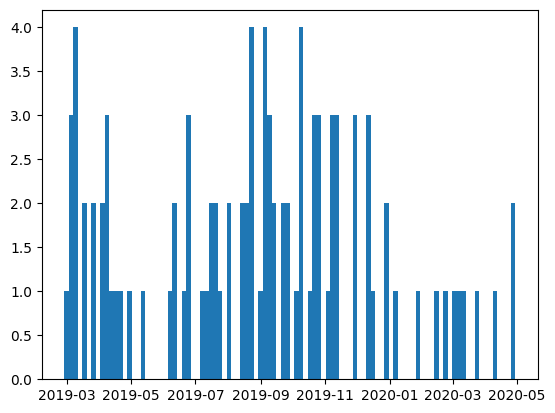

In [36]:
_ = plt.hist(temp, bins=100)
plt.show()

### Create DexRay Model with Keras

In [40]:
model_architecture = Sequential()
model_architecture.add(
    Conv1D(
        filters=64,
        kernel_size=12,
        activation="relu",
        input_shape=(IMG_SIZE * IMG_SIZE, 1),
    )
)
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Conv1D(filters=128, kernel_size=12, activation="relu"))
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Flatten())
model_architecture.add(Dense(64, activation="sigmoid"))
model_architecture.add(Dense(1, activation="sigmoid"))

model = keras.models.clone_model(model_architecture)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
)

### Tesseract

Split the data with Tesseract's `time_aware_train_test_split`

In [49]:
splits = temporal.time_aware_train_test_split(
    X, y, temp, train_size=6, test_size=1, granularity='month'
)
X_train, X_test, y_train, y_test, t_train, t_test = splits

print(f"X_train: {len(X_train)}") # Sanity Check
print(f"X_test: {len(X_test)}") # Sanity Check

X_train: 46
X_test: 9


In [50]:
results = evaluation.fit_predict_update(model, *splits)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 469ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
1it [00:03,  3.10s/it]

1/1 [==============================] - 0s 142ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2it [00:03,  1.68s/it]

1/1 [==============================] - 0s 245ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
3it [00:03,  1.24s/it]

1/1 [==============================] - 0s 106ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
4it [00:03,  1.02it/s]

1/1 [==============================] - 0s 137ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
5it [00:04,  1.20it/s]

1/1 [==============================] - 0s 49ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
6it [00:04,  1.39it/s]

1/1 [==============================] - 0s 212ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
7it [00:04,  1.50it/s]

1/1 [==============================] - 0s 135ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
8it [00:04,  1.63it/s]

1/1 [==============================] - 0s 90ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [51]:
metrics.print_metrics(results)

------------+---------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9   
------------+---------------------------------------------------------------
Actual pos  |      6      7      2      4      2      2      1      1      1
Actual neg  |      6      6      6      3      1      1      3      1      0
Total       |     12     13      8      7      3      3      4      2      1
------------+---------------------------------------------------------------
TPR         |  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
FPR         |  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000    nan
TNR         |  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000    nan
FNR         |  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
AUC ROC     |  0.917  0.429  0.500  1.000  1.000  0.000  0.667  1.000    nan
------------+-------------------------------------------------------------